# Rolling Planning mit Tardiness (Max)

In [1]:
import pandas as pd
import time
pd.set_option('display.max_rows', 20)

In [2]:
import utils.presenter as show
import utils.checker as check

import utils.rescheduling_solver_tardiness as rssv

from ProductionDaySimulation import ProductionDaySimulation

In [3]:
import utils.rolling_planning.init_jobs_times as rp_init
import utils.rolling_planning.procedure as rp_proced

## Laden der Initialisierungsdaten

In [4]:
df_jssp = pd.read_csv("data/05_tardiness_all_jssp.csv")
df_times = pd.read_csv("data/05_tardiness_all_times.csv")

### Tag 0 

In [5]:
df_plan = pd.read_csv("data/05_tardiness_init_plan.csv")
df_execution = pd.read_csv("data/05_tardiness_init_execution.csv")
df_undone = pd.read_csv("data/05_tardiness_init_undone.csv")

### Settings

In [6]:
max_time = 60*60*6 # 6h

In [7]:
def get_schedule_filename(prefix: str = "", day: int = 0, data_txt: str = "schedule", suffix: str = "") -> str:
    file_template = "data/{prefix}_{data}_{day:02d}{suffix}.csv"
    if suffix:
        suffix = f"_{suffix}"
    return file_template.format(prefix=prefix,data=data_txt,day=day, suffix=suffix)

## Params

In [8]:
# fix
day_length = 1440
horizon_days = 3

notebook_prefix = "6a"

#### Rescheduling für Tage 1-5
- Tag 1: Ankunfttermine in [1, 2, 3] + unabgeschlosse von Vortagen (evtl. Tag 0)
- Tag 2: Ankunfttermine in [2, 3, 4] + unabgeschlosse von Vortagen (evtl. Tag 0 "oder" Tag 1)
- ...
- Tag 5: Ankunfttermine in [5, 6, 7] + unabgeschlosse von Vortagen

In [9]:
first_start = 1
last_planning_start = 5


Solver-Informationen:
  Maximale Tardiness      : 1264.2373
  Solver-Status           : Optimal
  Anzahl Variablen        : 22746
  Anzahl Constraints      : 44758

  Scheduling-Dauer: 360 Minuten und 0.82 Sekunden.


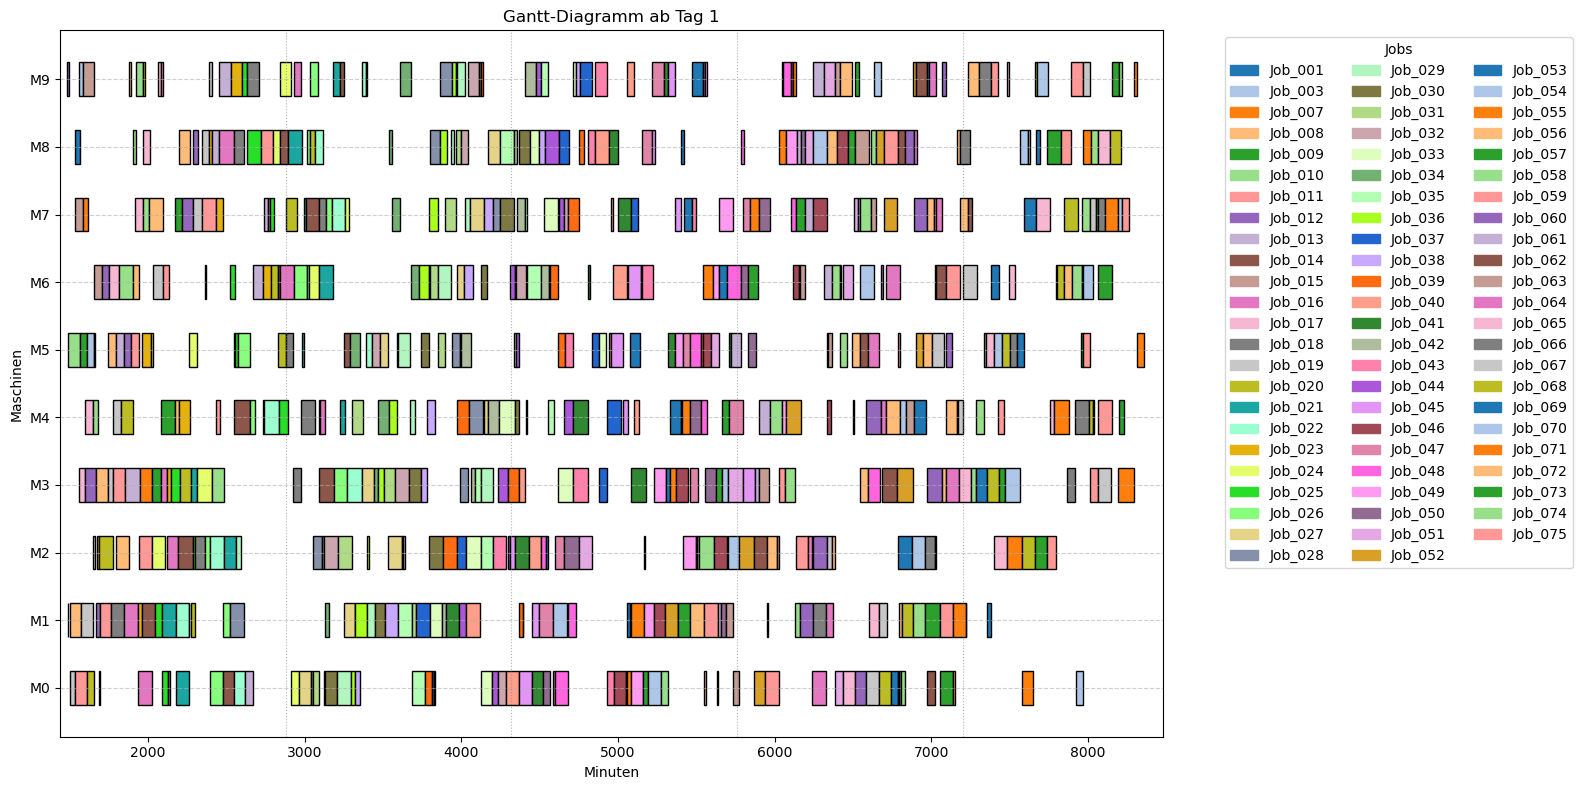

+ Keine Maschinenkonflikte gefunden
+ Für alle Jobs ist die Operationssequenz korrekt.
+ Zeitliche technologische Reihenfolge korrekt.
+ Alle Operation starten erst nach Arrival des Job

+++ Alle Constraints wurden erfüllt.

<0             0
0            438
0-30          16
30-60         12
60-120        15
120-240       26
240-480       70
480-720       48
720-1440      36
1440-2880      0
>2880          0
dtype: int64
[24:46:06] Job_012 started on M9
[24:50:27] Job_010 started on M5
[24:50:27] Job_013 started on M1
[24:51:34] Job_013 finished on M1 (after 01 minute 07 seconds)
[25:03:38] Job_012 finished on M9 (after 17 minutes 32 seconds)
[25:05:01] Job_008 started on M1
[25:05:01] Job_019 started on M0
[25:28:09] Job_010 finished on M5 (after 37 minutes 42 seconds)
[25:30:39] Job_019 finished on M0 (after 25 minutes 38 seconds)
[25:34:01] Job_011 started on M0
[25:34:13] Job_001 started on M8
[25:34:13] Job_015 started on M7
[26:01:38] Job_003 started on M9
[26:01:38] Job_017 star

NameError: name 'plot_results' is not defined

In [10]:
for day_numb in range(first_start, last_planning_start + 1):
    day_start = day_length * day_numb
    day_end = day_start + day_length
    planning_end = day_start + horizon_days * day_length

    # ------------------- I. Ankunfts- und Operationsvorbereitung -------------------
    df_jssp_curr, df_times_curr = rp_proced.filter_jobs_by_arrival_window(df_times, df_jssp, day_start, planning_end)
    df_jssp_curr = rp_proced.extend_with_undone_operations(df_jssp_curr, df_undone)
    df_times_curr = rp_proced.update_times_after_operation_changes(df_times, df_jssp_curr)

    # ------------------- II. Relevante laufende Operationen -------------------------
    df_execution_important = rp_proced.get_operations_running_into_day(df_execution, day_start)

    # ------------------- III. Rescheduling durchführen -------------------------------

    starting_time = time.time()
    df_plan = rssv.solve_jssp_max_tardiness_with_fixed_ops(df_jssp_curr, df_times_curr, df_execution_important,
                                                           reschedule_start = day_start,
                                                           solver= "HiGHS", msg=False, timeLimit=max_time, gapRel= 0.05, threads=7)
    solver_duration = time.time() - starting_time
    print(f"\n  Scheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")

    df_plan.to_csv(get_schedule_filename(notebook_prefix, day=day_numb), index=False)

    show.plot_gantt_machines(df_plan, title=f"Gantt-Diagramm ab Tag {day_numb}")
    check.check_constraints(df_plan)
    print(show.count_column_grouped(df_plan, 'Tardiness'))

    # ------------------- IV. Einen Tag simulieren -------------------------------------

    simulation = ProductionDaySimulation(df_plan, vc=0.35)
    df_execution, df_undone = simulation.run(start_time=day_start, end_time=day_end)
    if not df_execution.empty:
        show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm für Simulationstag {day_numb}", duration_column="Simulated Processing Time")
    else:
        print(f"Nothing executed on day {day_numb}")
    
